In [1]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import bayes3d as b
import jax.numpy as jnp
from random import randint
import pytorch3d.transforms
import jax
from jax.scipy.spatial.transform import Rotation as R

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

GenJAX not installed. Importing bayes3d without genjax dependencies.


device(type='cuda')

In [2]:
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=300.0, fy=300.0,
    cx=100.0, cy=100.0,
    near=0.01, far=2.5
)
fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2
fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2
tan_fovx = math.tan(fovX)
tan_fovy = math.tan(fovY)


def getProjectionMatrix(intrinsics):
    top = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    bottom = -top
    right = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * intrinsics.near / (right - left)
    P[1, 1] = 2.0 * intrinsics.near / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[2, 2] = z_sign * (intrinsics.far + intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[2, 3] = -2.0 * (intrinsics.far * intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[3, 2] = z_sign
    return torch.transpose(P, 0, 1)

proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)

/var/tmp/ipykernel_243752/3999498306.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7023/static/


In [3]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(5).rjust(6, '0') + ".ply")
mesh = b.utils.load_mesh(mesh_path)
vertices = torch.tensor(np.array(jnp.array(mesh.vertices) / 1000.0),device=device)

In [4]:
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=300.0, fy=300.0,
    cx=100.0, cy=100.0,
    near=0.01, far=2.5
)
fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2
fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2
tan_fovx = math.tan(fovX)
tan_fovy = math.tan(fovY)


def getProjectionMatrix(intrinsics):
    top = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    bottom = -top
    right = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * intrinsics.near / (right - left)
    P[1, 1] = 2.0 * intrinsics.near / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[2, 2] = z_sign * (intrinsics.far + intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[2, 3] = -2.0 * (intrinsics.far * intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[3, 2] = z_sign
    return torch.transpose(P, 0, 1)

proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)

/var/tmp/ipykernel_1722458/3999498306.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)


In [5]:
def posevec_to_matrix(position, quat):
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quat), position.unsqueeze(1)), 1),
            torch.tensor([[0.0, 0.0, 0.0, 1.0]],device=device),
        ),
        0,
    )
def apply_transform(points, transform):
    rels_ = torch.cat(
        (
            points,
            torch.ones((points.shape[0], 1),  device=device),
        ),
        1,
    )
    return torch.einsum("ij, aj -> ai", transform, rels_)[...,:3]
# position = torch.tensor([0.0, 0.1, 0.2], device=device)
# quat = torch.tensor([1.0, 0.1, 0.2, 0.3],device=device)
# points = torch.zeros((5,3), device = device)
# print(apply_transform(points, posevec_to_matrix(position, quat)))

In [14]:
camera_pose_jax = jnp.eye(4)
proj_matrix = b.utils.jax_to_torch(b.camera.getProjectionMatrix(intrinsics))
view_matrix = torch.transpose(torch.tensor(np.array(b.inverse_pose(camera_pose_jax))),0,1).cuda()
raster_settings = GaussianRasterizationSettings(
    image_height=int(intrinsics.height),
    image_width=int(intrinsics.width),
    tanfovx=tan_fovx,
    tanfovy=tan_fovy,
    bg=torch.tensor([1.0, 1.0, 1.0]).cuda(),
    scale_modifier=1.0,
    viewmatrix=view_matrix,
    projmatrix=view_matrix @ proj_matrix,
    sh_degree=0,
    campos=torch.zeros(3).cuda(),
    prefiltered=False,
    debug=None
)
rasterizer = GaussianRasterizer(raster_settings=raster_settings)


tensor([[0.4598, 0.8111, 0.1694],
        [0.7917, 0.2896, 0.7091],
        [0.5743, 0.0817, 0.7726],
        [0.0870, 0.0230, 0.0760],
        [0.7392, 0.6058, 0.0697],
        [0.7764, 0.2994, 0.3067],
        [0.9294, 0.1959, 0.6216],
        [0.2061, 0.5689, 0.1203],
        [0.4130, 0.4400, 0.9673],
        [0.4440, 0.3033, 0.8036]], device='cuda:0')


/var/tmp/ipykernel_243752/4006765285.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means3D = torch.tensor(torch.rand((10,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
/var/tmp/ipykernel_243752/4006765285.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
/var/tmp/ipykernel_243752/4006765285.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colors_precomp_gt = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device)

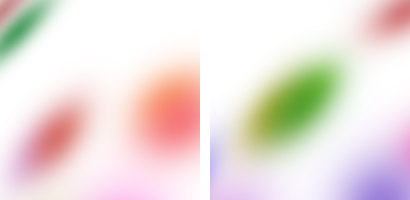

In [191]:
means3D = torch.tensor(torch.rand((10,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
means2D = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
N = means3D.shape[0]
opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
colors_precomp_gt = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device).detach()
scales = torch.tensor(-8.0 * torch.ones((N,3)), requires_grad=True, device=device)
rotations = torch.tensor(-10.0 * torch.ones((N,4)), requires_grad=True, device=device)

color,radii = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = colors_precomp_gt,
    opacities = torch.sigmoid(opacity),
    scales = torch.exp(scales),
    rotations = rotations
)
print(colors_precomp_gt)
color_gt = color.detach()
gt_viz = b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy() * 255.0)
gt_viz

means3D = torch.tensor(torch.rand((10,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
means2D = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
N = means3D.shape[0]
opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
colors_precomp = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device)
scales = torch.tensor(-8.0 * torch.ones((N,3)), requires_grad=True, device=device)
rotations = torch.tensor(-10.0 * torch.ones((N,4)), requires_grad=True, device=device)
color,_ = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = colors_precomp,
    opacities = torch.sigmoid(opacity),
    scales = torch.exp(scales),
    rotations = rotations
)

b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy() * 255.0),
    gt_viz
])

0.006673115771263838: 100%|██████████| 100/100 [00:00<00:00, 392.63it/s]


gt  tensor([[0.4598, 0.8111, 0.1694],
        [0.7917, 0.2896, 0.7091],
        [0.5743, 0.0817, 0.7726],
        [0.0870, 0.0230, 0.0760],
        [0.7392, 0.6058, 0.0697],
        [0.7764, 0.2994, 0.3067],
        [0.9294, 0.1959, 0.6216],
        [0.2061, 0.5689, 0.1203],
        [0.4130, 0.4400, 0.9673],
        [0.4440, 0.3033, 0.8036]], device='cuda:0')
current  tensor([[ 0.9418,  0.9438,  0.0853],
        [ 0.1936,  0.6242,  0.3092],
        [ 0.6001,  0.5943,  0.0482],
        [ 0.0016,  0.5116, -0.1347],
        [ 0.4469,  0.3065,  0.8037],
        [ 0.9343,  0.1990,  0.6247],
        [ 0.5674,  0.6746,  0.7904],
        [ 0.7789,  0.4523,  0.4558],
        [ 0.6118,  0.2299,  0.7700],
        [ 0.7669,  0.2867,  0.2948]], device='cuda:0', requires_grad=True)


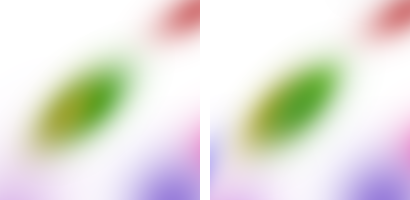

In [194]:
optimizer = torch.optim.Adam([
    {'params': [colors_precomp], 'lr': 0.01, "name": "pos"},
    {'params': [means3D], 'lr': 0.01, "name": "pos"},
], lr=0.0, eps=1e-15)

pbar = tqdm(range(100))
for _ in pbar:
    color,_ = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = colors_precomp,
        opacities = torch.sigmoid(opacity),
        scales = torch.exp(scales),
        rotations = rotations
    )
    optimizer.zero_grad()
    loss = torch.abs(color_gt - color).mean()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
print("gt ",colors_precomp_gt)
print("current ",colors_precomp)
b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy() * 255.0),
    gt_viz
])

gt  tensor([[0.0730, 0.7539, 0.5722]], device='cuda:0')
current  tensor([[0.1877, 0.2038, 0.1780]], device='cuda:0', requires_grad=True)
grad  tensor([[ 0.0284, -0.0744, -0.0744]], device='cuda:0')


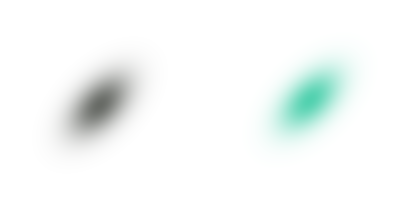

In [152]:
color,_ = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = colors_precomp,
    opacities = torch.sigmoid(opacity),
    scales = torch.exp(scales),
    rotations = rotations
)
loss = torch.abs(color_gt - color).mean()
loss.backward()
print("gt ",colors_precomp_gt)
print("current ",colors_precomp)
print("grad ", colors_precomp.grad)

with torch.no_grad():
    colors_precomp.copy_(colors_precomp - colors_precomp.grad)

b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy() * 255.0),
    gt_viz
])